## Defining modules/packages to import

In [54]:
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy

# importing package to recognize stop words i.e. the, and, an etc
from spacy.lang.en.stop_words import STOP_WORDS
stop_words = spacy.lang.en.stop_words.STOP_WORDS

import datetime

import plotly.express as px

stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [55]:
# importing module to ignore the warnings
import warnings
warnings.simplefilter('ignore')

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Defining functions to be used

In [57]:
#### Now creating some functions to do text processing
# Removing hashtags and mentions
def get_hashtags(text):
    hashtags = re.findall(r'\#\w+',text.lower())
    return hashtags
def get_mentions(text):
    mentions = re.findall(r'\@\w+',text.lower())
    return mentions

# Cleaning up the text of the tweets
def remove_content(text):
    text = re.sub(r"http\S+", "", text) #remove urls
    text=re.sub(r'\S+\.com\S+','',text) #remove urls
    text=re.sub(r'\@\w+','',text) #remove mentions
    text =re.sub(r'\#\w+','',text) #remove hashtags
    return text

def process_tweet(tweet):
    """ 
    tweets cleaning by 
    1) lowering the case of the tweet, 
    2) removing unwanted symbols and replacing them with a whitespace, 
    3) split sentences into words according to whitespaces and then 
    4) join back with a single whitespace as separator between various words
    """
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

def process_text(text, stem=False): #clean text
    text=remove_content(text)
    lemmatizer=WordNetLemmatizer()
    text = re.sub('[^A-Za-z]', ' ', text.lower()) #remove non-alphabets
    text = re.sub(r"\bamp\b", ' ', text.lower()) #remove "amp" which is coming from the translation of &
    text = re.sub(r"\bco\b", ' ', text.lower()) #remove "co" which was one of the top words found below
    tokenized_text = word_tokenize(text) #tokenize
    #tokenized_text = [lemmatizer.lemmatize(word) for word in tokenized_text]
    clean_text = [
         word for word in tokenized_text
         if (word not in stop_words and len(word)>1)
    ]
    if stem:
        clean_text=[stemmer.stem(word) for word in clean_text]
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text]
    return ' '.join(clean_text)

#functions used to remove search terms from all the tweets
#function to remove duplicates from a string - in this case the string is the keywords used to scrape the tweets
def removeDupWithoutOrder(string): 
    words = string.lower().split()
    return " ".join(sorted(set(words), key=words.index)).replace('OR', '').replace('  ', ' ')

#function to search for string (i.e. tweet in this case) and remove specific words (search_terms in this case)
def remove_search(text, search_terms):
    query = text.lower()
    querywords = query.split()
    resultwords  = [word for word in querywords if word.lower() not in search_terms]
    return ' '.join(resultwords)

# define function to plot frequency of bi-grams, tri-grams, single words, phrases etc
from sklearn.feature_extraction.text import CountVectorizer
def plot_topn(sentences, ngram_range=(1,3), top=20,firstword=''):
    c=CountVectorizer(ngram_range=ngram_range)
    X=c.fit_transform(sentences)
    words=pd.DataFrame(X.sum(axis=0),columns=c.get_feature_names()).T.sort_values(0,ascending=False).reset_index()
    res=words[words['index'].apply(lambda x: firstword in x)].head(top)
    pl=px.bar(res, x='index',y=0)
    pl.update_layout(yaxis_title='count',xaxis_title='Phrases')
    pl.show('png')

## Search terms used to do tweet scraping

In [58]:
search_terms = ["extinction rebellion", "Greta Thunberg", "climate", "global warming"]

## Now importing database to do analysis

In [62]:
# importing scraped database and putting it in df1516, taking only the columns below

#directory to google drive file
DIR = "drive/My Drive/Colab Notebooks"

df1516_dir = '{}{}'.format(DIR, '/env_df1516.pkl')
df1516 = pd.read_pickle(df1516_dir)[['date','tweet','nlikes','nreplies','nretweets']]



In [63]:
df1516.head(5)

,date,tweet,nlikes,nreplies,nretweets
0,2016-02-18 16:54:04,Global warming more like a global cooldown t =...,0,0,0
1,2016-02-18 16:54:08,control this 'global warming' in my pussy,0,0,0
2,2016-02-18 16:54:42,""" Dont worry.There are plenty of other viruses...",0,0,0
3,2016-02-18 16:54:45,Freeman Dyson and global warming https://t.co...,0,0,0
4,2016-02-18 16:54:55,Global warming more like a global cooldown t =...,0,0,0


In [64]:
# taking the 'date' column (which is a string) and extracting date, times, breaking it down in months, years etc

df1516['INCDTTM'] =  pd.to_datetime(df1516['date'], infer_datetime_format=True)
df1516['Time'] = [datetime.datetime.time(d) for d in df1516['INCDTTM']] 
df1516['Date'] = [datetime.datetime.date(d) for d in df1516['INCDTTM']]
df1516['Year'] = [datetime.datetime.date(d).year for d in df1516['INCDTTM']] 
df1516['Month'] = [datetime.datetime.date(d).month for d in df1516['INCDTTM']] 
df1516['Day'] = [datetime.datetime.date(d).day for d in df1516['INCDTTM']] 
df1516['Hours'] = [datetime.datetime.time(d).hour for d in df1516['INCDTTM']] 
df1516['Minutes'] = [datetime.datetime.time(d).minute for d in df1516['INCDTTM']] 
df1516['Seconds'] = [datetime.datetime.time(d).second for d in df1516['INCDTTM']]
df1516 = df1516.drop(columns = ['date','INCDTTM'])
df1516.head()

,tweet,nlikes,nreplies,nretweets,Time,Date,Year,Month,Day,Hours,Minutes,Seconds
0,Global warming more like a global cooldown t =...,0,0,0,16:54:04,2016-02-18,2016,2,18,16,54,4
1,control this 'global warming' in my pussy,0,0,0,16:54:08,2016-02-18,2016,2,18,16,54,8
2,""" Dont worry.There are plenty of other viruses...",0,0,0,16:54:42,2016-02-18,2016,2,18,16,54,42
3,Freeman Dyson and global warming https://t.co...,0,0,0,16:54:45,2016-02-18,2016,2,18,16,54,45
4,Global warming more like a global cooldown t =...,0,0,0,16:54:55,2016-02-18,2016,2,18,16,54,55


In [65]:
# removing useless content (hashtags, mentions)
df1516['tweet']=df1516['tweet'].apply(lambda x: remove_content(x))

In [66]:
# Several functions applied here: processing the *tweet* to remove punctuation, hashtags, mentions
# then removing the search terms used to do the tweets scraping and re-process the *text* 

df1516['cleaned_tweets']=df1516['tweet'].apply(lambda x: process_tweet(x))

#this next row drops from the scraped tweets the same keywords that were used to perform the search.
#if these words are excluded, the sentiment analysis performed with text blob looks at the whole tweet 
#and can spit out a different sentiment wrt if leaving the search terms in. Perhaps worth test it out a bit
#and look at TextBlob with naivebayes too.

#df1516['cleaned_tweets']=df1516['cleaned_tweets'].apply(lambda x: remove_search(x, search_concat_unique))

df1516['cleaned_tweets']=df1516['cleaned_tweets'].apply(lambda x: process_text(x))

In [67]:
df1516.head()

,tweet,nlikes,nreplies,nretweets,Time,Date,Year,Month,Day,Hours,Minutes,Seconds,cleaned_tweets
0,Global warming more like a global cooldown t =...,0,0,0,16:54:04,2016-02-18,2016,2,18,16,54,4,global warming like global cooldown
1,control this 'global warming' in my pussy,0,0,0,16:54:08,2016-02-18,2016,2,18,16,54,8,control global warming pussy
2,""" Dont worry.There are plenty of other viruses...",0,0,0,16:54:42,2016-02-18,2016,2,18,16,54,42,dont worry plenty virus coming global warming
3,Freeman Dyson and global warming via,0,0,0,16:54:45,2016-02-18,2016,2,18,16,54,45,freeman dyson global warming
4,Global warming more like a global cooldown t =...,0,0,0,16:54:55,2016-02-18,2016,2,18,16,54,55,global warming like global cooldown


In [68]:
# taking the cleaning tweets and dividing them using the space - cleaned tweets contain tweets that are stemmed and cleaned
tweet_list = df1516['cleaned_tweets'].tolist()
all_words=' '.join(tweet_list).split()

In [ ]:
plot_topn(tweet_list, ngram_range=(1,1))

In [ ]:
plot_topn(tweet_list, ngram_range=(2,2))

In [ ]:
plot_topn(tweet_list, ngram_range=(3,3))

## Wordcloud of most used words

In [69]:
from wordcloud import WordCloud, STOPWORDS
temp=' '.join(df1516['cleaned_tweets'].tolist())
wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white',
                min_font_size = 10).generate(temp)

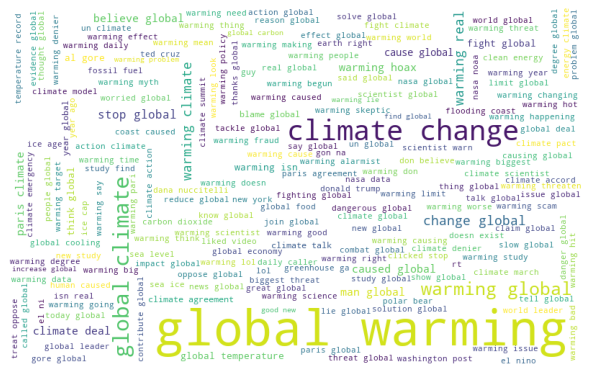

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off")
plt.tight_layout(pad = 0) 
  
plt.show('png')

## Sentiment analysis

In [71]:
from textblob import TextBlob 

def get_tweet_sentiment(tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweet) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'    

In [72]:
df1516.head()

,tweet,nlikes,nreplies,nretweets,Time,Date,Year,Month,Day,Hours,Minutes,Seconds,cleaned_tweets
0,Global warming more like a global cooldown t =...,0,0,0,16:54:04,2016-02-18,2016,2,18,16,54,4,global warming like global cooldown
1,control this 'global warming' in my pussy,0,0,0,16:54:08,2016-02-18,2016,2,18,16,54,8,control global warming pussy
2,""" Dont worry.There are plenty of other viruses...",0,0,0,16:54:42,2016-02-18,2016,2,18,16,54,42,dont worry plenty virus coming global warming
3,Freeman Dyson and global warming via,0,0,0,16:54:45,2016-02-18,2016,2,18,16,54,45,freeman dyson global warming
4,Global warming more like a global cooldown t =...,0,0,0,16:54:55,2016-02-18,2016,2,18,16,54,55,global warming like global cooldown


In [73]:
df1516['sentiment']=df1516['cleaned_tweets'].apply(lambda x: get_tweet_sentiment(x))

In [74]:
df1516.head(5)

,tweet,nlikes,nreplies,nretweets,Time,Date,Year,Month,Day,Hours,Minutes,Seconds,cleaned_tweets,sentiment
0,Global warming more like a global cooldown t =...,0,0,0,16:54:04,2016-02-18,2016,2,18,16,54,4,global warming like global cooldown,neutral
1,control this 'global warming' in my pussy,0,0,0,16:54:08,2016-02-18,2016,2,18,16,54,8,control global warming pussy,neutral
2,""" Dont worry.There are plenty of other viruses...",0,0,0,16:54:42,2016-02-18,2016,2,18,16,54,42,dont worry plenty virus coming global warming,neutral
3,Freeman Dyson and global warming via,0,0,0,16:54:45,2016-02-18,2016,2,18,16,54,45,freeman dyson global warming,neutral
4,Global warming more like a global cooldown t =...,0,0,0,16:54:55,2016-02-18,2016,2,18,16,54,55,global warming like global cooldown,neutral


In [75]:
df1516.sentiment.value_counts()

neutral     557842
positive    268942
negative    174333
Name: sentiment, dtype: int64

In [76]:
df1516['Positive']= df1516['sentiment'].apply(lambda x: 1 if (x=="positive")  else 0)
df1516['Negative']= df1516['sentiment'].apply(lambda x: 1 if (x=="negative")  else 0)
df1516['Neutral']= df1516['sentiment'].apply(lambda x: 1 if (x=="neutral")  else 0)

df1516.head()

,tweet,nlikes,nreplies,nretweets,Time,Date,Year,Month,Day,Hours,Minutes,Seconds,cleaned_tweets,sentiment,Positive,Negative,Neutral
0,Global warming more like a global cooldown t =...,0,0,0,16:54:04,2016-02-18,2016,2,18,16,54,4,global warming like global cooldown,neutral,0,0,1
1,control this 'global warming' in my pussy,0,0,0,16:54:08,2016-02-18,2016,2,18,16,54,8,control global warming pussy,neutral,0,0,1
2,""" Dont worry.There are plenty of other viruses...",0,0,0,16:54:42,2016-02-18,2016,2,18,16,54,42,dont worry plenty virus coming global warming,neutral,0,0,1
3,Freeman Dyson and global warming via,0,0,0,16:54:45,2016-02-18,2016,2,18,16,54,45,freeman dyson global warming,neutral,0,0,1
4,Global warming more like a global cooldown t =...,0,0,0,16:54:55,2016-02-18,2016,2,18,16,54,55,global warming like global cooldown,neutral,0,0,1


In [77]:
df1516_timeline = df1516.groupby(df1516.Date).sum().reset_index()
df1516_timeline['Total'] = df1516_timeline.Positive + df1516_timeline.Negative + df1516_timeline.Neutral
df1516_timeline

,Date,nlikes,nreplies,nretweets,Year,Month,Day,Hours,Minutes,Seconds,Positive,Negative,Neutral,Total
0,2015-10-01,1815,317,2105,5565430,27620,2762,0,0,0,672,394,1696,2762
1,2015-10-02,1968,412,2239,5174520,25680,5136,0,0,0,633,340,1595,2568
2,2015-10-03,1015,229,1118,3330795,16530,4959,0,0,0,360,226,1067,1653
3,2015-10-04,957,324,1045,3435575,17050,6820,0,0,0,420,239,1046,1705
4,2015-10-05,1315,254,1554,4027985,19990,9995,0,0,0,620,319,1060,1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2016-09-27,77699,3731,59678,22188096,99054,297162,73848,316501,320606,2893,1458,6655,11006
363,2016-09-28,4188,718,3129,4947264,22086,68712,29435,69510,68139,694,434,1326,2454
364,2016-09-29,3479,655,2526,4870656,21744,70064,31472,70207,67721,714,538,1164,2416
365,2016-09-30,3394,398,2888,4054176,18099,60330,24256,58758,54144,509,451,1051,2011


In [78]:
import numpy as np
from datetime import datetime, timedelta

t = np.arange(df1516_timeline.Date[0], df1516_timeline.Date[365], timedelta(days=7)).astype(datetime)

In [ ]:
#plt.figure(figsize=(20,5))
#plt.bar(df1516_timeline.Date, (df1516_timeline['Positive']/df1516_timeline['Total']));
#plt.bar(df1516_timeline.Date, (df1516_timeline['Negative']/df1516_timeline['Total']), bottom = (df1516_timeline['Positive']/df1516_timeline['Total']));
#plt.legend(['Positive', 'Negative']);
#plt.xticks(t, rotation='vertical');
#plt.ylabel('Number of positive and negative tweets');
#plt.xlabel('Date');

In [79]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()
fig.add_bar(x=df1516_timeline.Date, y=100*df1516_timeline.Negative/(df1516_timeline.Total), name="% Negative")
fig.add_bar(x=df1516_timeline.Date, y=100*df1516_timeline.Positive/(df1516_timeline.Total), name="% Positive")
fig.add_bar(x=df1516_timeline.Date, y=100*df1516_timeline.Neutral/df1516_timeline.Total, name="% Neutral")
fig.add_trace(go.Scatter(x=[df1516_timeline.Date[0], df1516_timeline.Date[365]],y=[50,50],name="50% threshold"))
fig.update_layout(barmode="relative")
fig.update_layout(showlegend=True,title="Tweets split by sentiment: % positive, % negative and % neutral",
                 yaxis_title="% of total tweets", xaxis_title="Time")
fig.show()

### Some further analyses on percentages of positive/negative/neutral tweets and saving them locally

In [80]:
df1516_new = df1516_timeline[['Date', 'Negative','Positive','Neutral','Total']].copy()

In [81]:
df1516_new['Percentage_neg'] = 100*(df1516_new.Negative/df1516_new.Total)
df1516_new['Percentage_pos'] = 100*(df1516_new.Positive/df1516_new.Total)
df1516_new['Percentage_neutr'] = 100*(df1516_new.Neutral/df1516_new.Total)
df1516_new.head()

,Date,Negative,Positive,Neutral,Total,Percentage_neg,Percentage_pos,Percentage_neutr
0,2015-10-01,394,672,1696,2762,14.265025,24.330196,61.404779
1,2015-10-02,340,633,1595,2568,13.239875,24.649533,62.110592
2,2015-10-03,226,360,1067,1653,13.672111,21.778584,64.549304
3,2015-10-04,239,420,1046,1705,14.017595,24.633431,61.348974
4,2015-10-05,319,620,1060,1999,15.957979,31.015508,53.026513


In [82]:
df1516_new.shape

(367, 8)

In [83]:
df1516_new.to_csv('env_2015_2016_postprocessed.csv', index=False)


### Now we turn our attention to the reactions and engagements - by categories: likes, replies, retweets. What is making more 'noise'? Negative or positive tweets?

In [84]:
reactions_vert = pd.DataFrame(columns=['Date', 'Positive_nlikes', 'Positive_nreplies', 'Positive_nretweets', 'Negative_nlikes', 'Negative_nreplies', 'Negative_nretweets', 'Neutral_nlikes', 'Neutral_nreplies', 'Neutral_nretweets', 'Total_nlikes', 'Total_nreplies', 'Total_nretweets'])

In [85]:
reactions_vert.Date = df1516.loc[df1516['Positive'] == 1].groupby(df1516.Date).sum().reset_index().Date
reactions_vert.Positive_nlikes = df1516.loc[df1516['Positive'] == 1].groupby(df1516.Date).sum().reset_index().nlikes
reactions_vert.Positive_nreplies = df1516.loc[df1516['Positive'] == 1].groupby(df1516.Date).sum().reset_index().nreplies
reactions_vert.Positive_nretweets = df1516.loc[df1516['Positive'] == 1].groupby(df1516.Date).sum().reset_index().nretweets

reactions_vert.Negative_nlikes = df1516.loc[df1516['Negative'] == 1].groupby(df1516.Date).sum().reset_index().nlikes
reactions_vert.Negative_nreplies = df1516.loc[df1516['Negative'] == 1].groupby(df1516.Date).sum().reset_index().nreplies
reactions_vert.Negative_nretweets = df1516.loc[df1516['Negative'] == 1].groupby(df1516.Date).sum().reset_index().nretweets

reactions_vert.Neutral_nlikes = df1516.loc[df1516['Neutral'] == 1].groupby(df1516.Date).sum().reset_index().nlikes
reactions_vert.Neutral_nreplies = df1516.loc[df1516['Neutral'] == 1].groupby(df1516.Date).sum().reset_index().nreplies
reactions_vert.Neutral_nretweets = df1516.loc[df1516['Neutral'] == 1].groupby(df1516.Date).sum().reset_index().nretweets

#cumulative total of likes, replies and retweets per day

reactions_vert.Total_nlikes = reactions_vert.Positive_nlikes + reactions_vert.Negative_nlikes + reactions_vert.Neutral_nlikes
reactions_vert.Total_nreplies = reactions_vert.Positive_nreplies + reactions_vert.Negative_nreplies + reactions_vert.Neutral_nreplies
reactions_vert.Total_nretweets = reactions_vert.Positive_nretweets + reactions_vert.Negative_nretweets + reactions_vert.Neutral_nretweets

In [86]:
reactions_vert.head()

,Date,Positive_nlikes,Positive_nreplies,Positive_nretweets,Negative_nlikes,Negative_nreplies,Negative_nretweets,Neutral_nlikes,Neutral_nreplies,Neutral_nretweets,Total_nlikes,Total_nreplies,Total_nretweets
0,2015-10-01,343,66,342,560,68,600,912,183,1163,1815,317,2105
1,2015-10-02,686,114,475,355,60,489,927,238,1275,1968,412,2239
2,2015-10-03,226,46,186,184,35,144,605,148,788,1015,229,1118
3,2015-10-04,126,55,113,307,69,298,524,200,634,957,324,1045
4,2015-10-05,289,81,423,180,29,163,846,144,968,1315,254,1554


In [87]:
reactions_vert.shape

(367, 13)

In [88]:
reactions_vert.to_csv('env_2015_2016_reactions_vert.csv', index=False)


In [89]:
reactions_perc_v = pd.DataFrame(columns=['Date', 'Positive_nlikes', 'Positive_nreplies', 'Positive_nretweets', 'Negative_nlikes', 'Negative_nreplies', 'Negative_nretweets', 'Neutral_nlikes', 'Neutral_nreplies', 'Neutral_nretweets'])

reactions_perc_v.Date = reactions_vert.Date

# Now defining percentages of each reaction (like or reply or retweet) wrt to their total across sentiment. 
# By doing so we're calculating how each reaction is split by **sentiment** 

reactions_perc_v.Positive_nlikes = 100*reactions_vert.Positive_nlikes/reactions_vert.Total_nlikes
reactions_perc_v.Positive_nreplies = 100*reactions_vert.Positive_nreplies/reactions_vert.Total_nreplies
reactions_perc_v.Positive_nretweets = 100*reactions_vert.Positive_nretweets/reactions_vert.Total_nretweets

reactions_perc_v.Negative_nlikes = 100*reactions_vert.Negative_nlikes/reactions_vert.Total_nlikes
reactions_perc_v.Negative_nreplies = 100*reactions_vert.Negative_nreplies/reactions_vert.Total_nreplies
reactions_perc_v.Negative_nretweets = 100*reactions_vert.Negative_nretweets/reactions_vert.Total_nretweets

reactions_perc_v.Neutral_nlikes = 100*reactions_vert.Neutral_nlikes/reactions_vert.Total_nlikes
reactions_perc_v.Neutral_nreplies = 100*reactions_vert.Neutral_nreplies/reactions_vert.Total_nreplies
reactions_perc_v.Neutral_nretweets = 100*reactions_vert.Neutral_nretweets/reactions_vert.Total_nretweets

reactions_perc_v['Positive tweets'] = 100*df1516_timeline.Positive/df1516_timeline.Total
reactions_perc_v['Negative tweets'] = 100*df1516_timeline.Negative/df1516_timeline.Total
reactions_perc_v['Neutral tweets'] = 100*df1516_timeline.Neutral/df1516_timeline.Total

reactions_perc_v.head()

,Date,Positive_nlikes,Positive_nreplies,Positive_nretweets,Negative_nlikes,Negative_nreplies,Negative_nretweets,Neutral_nlikes,Neutral_nreplies,Neutral_nretweets,Positive tweets,Negative tweets,Neutral tweets
0,2015-10-01,18.898072,20.820189,16.247031,30.853994,21.451104,28.503563,50.247934,57.728707,55.249406,24.330196,14.265025,61.404779
1,2015-10-02,34.857724,27.669903,21.214828,18.038618,14.563107,21.840107,47.103659,57.766990,56.945065,24.649533,13.239875,62.110592
2,2015-10-03,22.266010,20.087336,16.636852,18.128079,15.283843,12.880143,59.605911,64.628821,70.483005,21.778584,13.672111,64.549304
3,2015-10-04,13.166144,16.975309,10.813397,32.079415,21.296296,28.516746,54.754441,61.728395,60.669856,24.633431,14.017595,61.348974
4,2015-10-05,21.977186,31.889764,27.220077,13.688213,11.417323,10.489060,64.334601,56.692913,62.290862,31.015508,15.957979,53.026513


In [90]:
reactions_perc_v.to_csv('env_2015_2016_reactions_perc_v.csv', index=False)



### Plots showing for each type of reactions, what's the split by sentiment - first by % then by absolute numbers

In [91]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Positive_nlikes, name="% Positive", row=1, col=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Negative_nlikes, name="% Negative", row=1, col=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Neutral_nlikes, name="% Neutral", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="'Likes' split by sentiment",
                 yaxis_title="% of likes", xaxis_title="Time")
fig.show()

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Positive_nreplies, name="% Positive", row=1, col=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Negative_nreplies, name="% Negative", row=1, col=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Neutral_nreplies, name="% Neutral", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="'Replies' split by sentiment",
                 yaxis_title="% of replies", xaxis_title="Time")
fig.show()

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Positive_nretweets, name="% Positive", row=1, col=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Negative_nretweets, name="% Negative", row=1, col=1)
fig.add_bar(x=reactions_perc_v.Date, y=reactions_perc_v.Neutral_nretweets, name="% Neutral", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="'Retweets' split by sentiment",
                 yaxis_title="% of retweets", xaxis_title="Time")
fig.show()


In [92]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Positive_nlikes, name="Positive", row=1, col=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Negative_nlikes, name="Negative", row=1, col=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Neutral_nlikes, name="Neutral", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="'Likes' split by sentiment",
                 yaxis_title="Number of likes", xaxis_title="Time")
fig.show()

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Positive_nreplies, name="Positive", row=1, col=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Negative_nreplies, name="Negative", row=1, col=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Neutral_nreplies, name="Neutral", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="'Replies' split by sentiment",
                 yaxis_title="Number of replies", xaxis_title="Time")
fig.show()

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Positive_nretweets, name="Positive", row=1, col=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Negative_nretweets, name="Negative", row=1, col=1)
fig.add_bar(x=reactions_vert.Date, y=reactions_vert.Neutral_nretweets, name="Neutral", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="'Retweets' split by sentiment",
                 yaxis_title="Number of retweets", xaxis_title="Time")
fig.show()


In [93]:
# Now we create a new dataframe to illustrate how each sentiment is split by reaction

reactions_hor = pd.DataFrame(columns=['Date', 'Positive_nlikes', 'Positive_nreplies', 'Positive_nretweets', 'Negative_nlikes', 'Negative_nreplies', 
                                  'Negative_nretweets', 'Neutral_nlikes', 'Neutral_nreplies', 'Neutral_nretweets', 
                                  'Total_Positive', 'Total_Negative', 'Total_Neutral'])

reactions_hor.Date = df1516.loc[df1516['Positive'] == 1].groupby(df1516.Date).sum().reset_index().Date
reactions_hor.Positive_nlikes = df1516.loc[df1516['Positive'] == 1].groupby(df1516.Date).sum().reset_index().nlikes
reactions_hor.Positive_nreplies = df1516.loc[df1516['Positive'] == 1].groupby(df1516.Date).sum().reset_index().nreplies
reactions_hor.Positive_nretweets = df1516.loc[df1516['Positive'] == 1].groupby(df1516.Date).sum().reset_index().nretweets

reactions_hor.Negative_nlikes = df1516.loc[df1516['Negative'] == 1].groupby(df1516.Date).sum().reset_index().nlikes
reactions_hor.Negative_nreplies = df1516.loc[df1516['Negative'] == 1].groupby(df1516.Date).sum().reset_index().nreplies
reactions_hor.Negative_nretweets = df1516.loc[df1516['Negative'] == 1].groupby(df1516.Date).sum().reset_index().nretweets

reactions_hor.Neutral_nlikes = df1516.loc[df1516['Neutral'] == 1].groupby(df1516.Date).sum().reset_index().nlikes
reactions_hor.Neutral_nreplies = df1516.loc[df1516['Neutral'] == 1].groupby(df1516.Date).sum().reset_index().nreplies
reactions_hor.Neutral_nretweets = df1516.loc[df1516['Neutral'] == 1].groupby(df1516.Date).sum().reset_index().nretweets

#cumulative total of (likes+replies+retweets) per day by sentiment

reactions_hor.Total_Positive = reactions_hor.Positive_nlikes + reactions_hor.Positive_nreplies + reactions_hor.Positive_nretweets
reactions_hor.Total_Negative = reactions_hor.Negative_nlikes + reactions_hor.Negative_nreplies + reactions_hor.Negative_nretweets
reactions_hor.Total_Neutral = reactions_hor.Neutral_nlikes + reactions_hor.Neutral_nreplies + reactions_hor.Neutral_nretweets

reactions_hor.head()

,Date,Positive_nlikes,Positive_nreplies,Positive_nretweets,Negative_nlikes,Negative_nreplies,Negative_nretweets,Neutral_nlikes,Neutral_nreplies,Neutral_nretweets,Total_Positive,Total_Negative,Total_Neutral
0,2015-10-01,343,66,342,560,68,600,912,183,1163,751,1228,2258
1,2015-10-02,686,114,475,355,60,489,927,238,1275,1275,904,2440
2,2015-10-03,226,46,186,184,35,144,605,148,788,458,363,1541
3,2015-10-04,126,55,113,307,69,298,524,200,634,294,674,1358
4,2015-10-05,289,81,423,180,29,163,846,144,968,793,372,1958


In [94]:
reactions_hor.to_csv('env_2015_2016_reactions_hor.csv', index=False)


In [95]:
reactions_perc_h = pd.DataFrame(columns=['Date', 'Positive_nlikes', 'Positive_nreplies', 'Positive_nretweets', 
                                         'Negative_nlikes', 'Negative_nreplies', 'Negative_nretweets', 
                                         'Neutral_nlikes', 'Neutral_nreplies', 'Neutral_nretweets'])

reactions_perc_h.Date = reactions_hor.Date

# Now defining percentages of each reaction (like or reply or retweet) wrt to their total across sentiment. 
# By doing so we're calculating how each reaction is split by **sentiment** 

reactions_perc_h.Positive_nlikes = 100*reactions_hor.Positive_nlikes/reactions_hor.Total_Positive
reactions_perc_h.Positive_nreplies = 100*reactions_hor.Positive_nreplies/reactions_hor.Total_Positive
reactions_perc_h.Positive_nretweets = 100*reactions_hor.Positive_nretweets/reactions_hor.Total_Positive

reactions_perc_h.Negative_nlikes = 100*reactions_hor.Negative_nlikes/reactions_hor.Total_Negative
reactions_perc_h.Negative_nreplies = 100*reactions_hor.Negative_nreplies/reactions_hor.Total_Negative
reactions_perc_h.Negative_nretweets = 100*reactions_hor.Negative_nretweets/reactions_hor.Total_Negative

reactions_perc_h.Neutral_nlikes = 100*reactions_hor.Neutral_nlikes/reactions_hor.Total_Neutral
reactions_perc_h.Neutral_nreplies = 100*reactions_hor.Neutral_nreplies/reactions_hor.Total_Neutral
reactions_perc_h.Neutral_nretweets = 100*reactions_hor.Neutral_nretweets/reactions_hor.Total_Neutral

reactions_perc_h['Positive tweets'] = 100*df1516_timeline.Positive/df1516_timeline.Total
reactions_perc_h['Negative tweets'] = 100*df1516_timeline.Negative/df1516_timeline.Total
reactions_perc_h['Neutral tweets'] = 100*df1516_timeline.Neutral/df1516_timeline.Total

reactions_perc_h.head()

,Date,Positive_nlikes,Positive_nreplies,Positive_nretweets,Negative_nlikes,Negative_nreplies,Negative_nretweets,Neutral_nlikes,Neutral_nreplies,Neutral_nretweets,Positive tweets,Negative tweets,Neutral tweets
0,2015-10-01,45.672437,8.788282,45.539281,45.602606,5.537459,48.859935,40.389725,8.104517,51.505757,24.330196,14.265025,61.404779
1,2015-10-02,53.803922,8.941176,37.254902,39.269912,6.637168,54.092920,37.991803,9.754098,52.254098,24.649533,13.239875,62.110592
2,2015-10-03,49.344978,10.043668,40.611354,50.688705,9.641873,39.669421,39.260221,9.604153,51.135626,21.778584,13.672111,64.549304
3,2015-10-04,42.857143,18.707483,38.435374,45.548961,10.237389,44.213650,38.586156,14.727541,46.686303,24.633431,14.017595,61.348974
4,2015-10-05,36.443884,10.214376,53.341740,48.387097,7.795699,43.817204,43.207354,7.354443,49.438202,31.015508,15.957979,53.026513


In [96]:
reactions_perc_h.to_csv('env_2015_2016_reactions_perc_h.csv', index=False)


### Plots showing for each type of sentiment, what's the split by reaction type - first by % then by absolute numbers

In [97]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Positive_nlikes, name="% Likes", row=1, col=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Positive_nreplies, name="% Replies", row=1, col=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Positive_nretweets, name="% Retweets", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="Reactions classification for positive tweets",
                 yaxis_title="% of reactions", xaxis_title="Time")
fig.show()

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Negative_nlikes, name="% Likes", row=1, col=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Negative_nreplies, name="% Replies", row=1, col=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Negative_nretweets, name="% Retweets", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="Reactions classification for negative tweets",
                 yaxis_title="% of reactions", xaxis_title="Time")
fig.show()

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Neutral_nlikes, name="% Likes", row=1, col=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Neutral_nreplies, name="% Replies", row=1, col=1)
fig.add_bar(x=reactions_perc_h.Date, y=reactions_perc_h.Neutral_nretweets, name="% Retweets", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="Reactions classification for neutral tweets",
                 yaxis_title="% of reactions", xaxis_title="Time")
fig.show()


In [98]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Positive_nlikes, name="Likes", row=1, col=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Positive_nreplies, name="Replies", row=1, col=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Positive_nretweets, name="Retweets", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="Reactions classification for positive tweets",
                 yaxis_title="Number of reactions", xaxis_title="Time")
fig.show()

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Negative_nlikes, name="Likes", row=1, col=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Negative_nreplies, name="Replies", row=1, col=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Negative_nretweets, name="Retweets", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="Reactions classification for negative tweets",
                 yaxis_title="Number of reactions", xaxis_title="Time")
fig.show()

fig = make_subplots(rows=1, cols=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Neutral_nlikes, name="Likes", row=1, col=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Neutral_nreplies, name="Replies", row=1, col=1)
fig.add_bar(x=reactions_hor.Date, y=reactions_hor.Neutral_nretweets, name="Retweets", row=1, col=1)
fig.update_layout(barmode="relative",showlegend=True,title="Reactions classification for neutral tweets",
                 yaxis_title="Number of reactions", xaxis_title="Time")
fig.show()
